In [4]:
import pandas as pd
import pickle

import sys
sys.path.append('C:\\Users\\Tim\\PycharmProjects\\625.687\src') # your local repo here

path = "C:\\Users\\Tim\\Desktop\\MillionSongSubsetMillionSongSubset_dataframe_test.pkl" # your local data here
big_path = "C:\\Users\\Tim\\Desktop\\MillionSongSubset_dataframe.track_id_year_segments_pitches.pkl"
df = pickle.load(open(path, "rb"))
for c in sorted(df.columns):
    print(c)

analysis_sample_rate
analyzer_version
artist_7digitalid
artist_familiarity
artist_hotttnesss
artist_id
artist_latitude
artist_location
artist_longitude
artist_mbid
artist_mbtags
artist_mbtags_count
artist_name
artist_playmeid
artist_terms
artist_terms_freq
artist_terms_weight
audio_md5
bars_confidence
bars_start
beats_confidence
beats_start
danceability
duration
end_of_fade_in
energy
genre
idx_artist_mbtags
idx_artist_terms
idx_bars_confidence
idx_bars_start
idx_beats_confidence
idx_beats_start
idx_sections_confidence
idx_sections_start
idx_segments_confidence
idx_segments_loudness_max
idx_segments_loudness_max_time
idx_segments_loudness_start
idx_segments_pitches
idx_segments_start
idx_segments_timbre
idx_similar_artists
idx_tatums_confidence
idx_tatums_start
key
key_confidence
loudness
mode
mode_confidence
release
release_7digitalid
sections_confidence
sections_start
segments_confidence
segments_loudness_max
segments_loudness_max_time
segments_loudness_start
segments_pitches
segments

In [68]:
'''
Find range of timbre
'''
    
def normalize_segments_timbre(segments_timbre_column):
    minimum = segments_timbre_column.iloc[0][0][0]
    maximum = segments_timbre_column.iloc[0][0][0]
    for series in segments_timbre_column:
        for vector in series:
            for score in vector:
                if score > maximum:
                    maximum = score
                if score < minimum:
                    minimum = score
    return minimum, maximum

normalize_segments_timbre(df["segments_timbre"])

(-446.323, 471.464)

In [59]:
'''
Vectorize segments_timbre
'''
import collections
import numpy as np
from scipy.stats import entropy

def segments_timbre_distribution(timbre_vector, minimum, maximum):
    """
    Constructs a 32 by 8 histogram; the 32 represents 32 timbre bins
    Goal is to create a single vector which captures timbre range and variety
    """
    # Space out the range [0,1] to 32 equally separated values
    bin_values = np.linspace(minimum, maximum, 32)
    timbre_bins = {}
    for timbre in range(12):
        timbre_bins[timbre] = collections.defaultdict(float)

    # Generate 2-D timbre frequency histogram
    for entry in timbre_vector:  # vector of 12 semitones (A->G#)
        for i in range(12):  # for each tone
            tone_idx = 0
            while entry[i] >= bin_values[tone_idx]:  # find the bin for that tone's value,
                if tone_idx == 31:
                    break
                tone_idx += 1
            timbre_bins[i][tone_idx] += 1  # then save it to tone_bins

    # Now, collapse the 2-D histogram into a 256-length feature vector
    return_vector = []
    normalization_factor = len(timbre_vector) # normalize, since more entries -> higher values due to length
    for i in range(12):
        for j in range(32):
            return_vector.append(timbre_bins[i][j] / normalization_factor)
    return return_vector


def vectorize_segments_timbre_average(timbre_vector, minimum, maximum):
    """
    For each timbre value, generate a sliding window of length 64. Then over those grouped values,
    compute entropy;
    """
    # Iterate over sliding windows of length 64
    num_windows = len(timbre_vector) // 64
    tone_means = collections.defaultdict(list)
    for window_index in range(num_windows + 1):
        i = window_index * 64
        j = (window_index + 1) * 64
        if j > len(timbre_vector):
            j = len(timbre_vector)

        # For each window, collect and group tone values
        tones_vector = collections.defaultdict(list)
        while i < j:
            for tone_idx in range(12):
                tones_vector[tone_idx].append(timbre_vector[i][tone_idx])
            i += 1

        # Compute entropy of tone value over each window for each tone
        for tone in tones_vector.keys():
            window_mean = np.mean(timbre_vector[window_index])  # is entropy what we want to measure here?
            tone_means[tone].append(window_mean)

    # Separate entropy values per tone into percentiles
    tone_percentiles = collections.defaultdict(list)
    percentiles = np.linspace(0, 1, 21)
    for tone in tone_means.keys():
        for p in percentiles:
            p = p * 100
            val = np.percentile(tone_means[tone], p)
            tone_percentiles[tone].append(val)

    # Now, collapse the 2-D histogram into a 256-length feature vector
    return_vector = [0, 0, 0, 0, ]  # four empty values; use for other metadata?
    for i in range(12):
        for j in range(21):
            return_vector.append(tone_percentiles[i][j])
    for i in range(len(return_vector)):
        if not isinstance(return_vector[i], float) or np.isnan(return_vector[i]):
            return_vector[i] = 0.
    return return_vector

In [65]:
minimum, maximum = normalize_segments_timbre(df["segments_timbre"])
#vectors = [segments_timbre_distribution(x, minimum, maximum) for x in df["segments_timbre"]]
vectors = [vectorize_segments_timbre_average(x, minimum, maximum) for x in df["segments_timbre"]]

In [72]:
subdf = df[["year", "segments_timbre"]]
subdf = subdf[subdf["year"] != 0]

minimum, maximum = normalize_segments_timbre(subdf["segments_timbre"])
timbre_features = [vectorize_segments_timbre_average(x, minimum, maximum) for x in subdf["segments_timbre"]]
subdf["timbre_features"] = timbre_features

In [73]:
import Metrics

mf = Metrics.Metric() # metric factory
metrics_df = []

# Compute a square matrix of scores (every song against every song)
for index1, row1 in subdf.iterrows():
    metric_scores = []
    for index2, row2 in subdf.iterrows():
        score = mf.L_2_norm(row1["timbre_features"], row2["timbre_features"])
        metric_scores.append(score)
    metrics_df.append(metric_scores)

Pseduom: 0.4157462830912271


In [75]:
radius = 2000 # picked a value after looking at the L2 outputs

# Group together elements which, for a given radius, have metric values less than some radius
# Using matrix indices to save groups; indices should stil align to position in subdf 

elements = set()
for i in range(len(metrics_df)):
    ball_centered_around_i = set()
    for j in range(len(metrics_df)):
        if metrics_df[i][j] < radius:
            ball_centered_around_i.add(j)
    ball = tuple(sorted(ball_centered_around_i))
    elements.add(ball)

In [79]:
# Generate simplicial complexes from the data
from itertools import combinations

def generate_simplicial_complexes(set_of_sets):
    """
    Treat each set like it represents a simplicial complex, and generate inclusion power sets all the way down
    (simplicial complexes are closed under interection; if (abc), then (ab), (ac), and (bc) must be in the set)
    """
    combs = set()
    for simplicial_complex in set_of_sets:
        #print(simplicial_complex, "\n")
        for i in range(1, 4):
            i_length_combos = combinations(simplicial_complex, i)
            for combo in i_length_combos:
                combs.add(tuple(sorted(combo)))
    return combs

complexes = generate_simplicial_complexes(elements)

In [80]:
import numpy as np

years = subdf["year"].values

ranges = []

for simplicial in complexes:
    x = [years[i] for i in simplicial]
    ranges.append(np.max(x) - np.min(x))

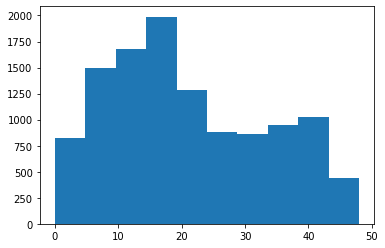

In [83]:
import matplotlib.pyplot as plt

plt.hist(ranges)
plt.show()

In [77]:
from sklearn import tree
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

clf = tree.DecisionTreeClassifier()
train_x, test_x, train_y, test_y =train_test_split(subdf["timbre_features"], subdf["year"],
                                                   test_size=0.2, random_state=666)

train_x = [np.asarray(x) for x in train_x]
train_y = [np.asarray(x) for x in train_y]
test_x = [np.asarray(x) for x in test_x]
test_y = [np.asarray(x) for x in test_y]

y_score = clf.fit(train_x, train_y).predict(test_x)

diffs = [abs(y_score[i] - test_y[i]) for i in range(len(y_score))]

Mean: 15.818181818181818
Stdv: 12.5973892087223
Mode: 3
Quantiles: [ 3.  5. 12. 25. 39.]


(array([3., 2., 1., 1., 1., 0., 0., 0., 2., 1.]),
 array([ 3. ,  6.6, 10.2, 13.8, 17.4, 21. , 24.6, 28.2, 31.8, 35.4, 39. ]),
 <BarContainer object of 10 artists>)

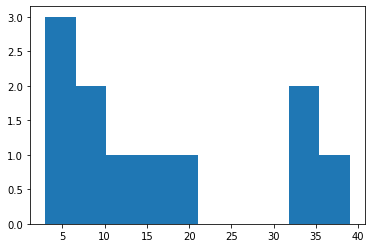

In [78]:
import matplotlib.pyplot as plt

print("Mean:", np.mean(diffs))
print("Stdv:", np.std(diffs))
print("Mode:", max(set(diffs), key=diffs.count))
print("Quantiles:", np.quantile(diffs, [0.0, 0.25, 0.5, 0.75, 1.]))

plt.hist(diffs)